In [60]:
%tensorflow_version 2.x

import time
import torch
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import vgg19
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input


torch.cuda.empty_cache()
gpu_name = tf.test.gpu_device_name()
cpu_name = '/cpu:0'
print(gpu_name)

In [61]:
from keras.datasets import mnist
(x_train, label_train), (x_test, label_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [0]:
# Encoder
encoder = models.Sequential()
encoder.add(Dense(128, input_shape=(784,), activation='relu'))
encoder.add(Dense( 64, activation='relu'))
encoder.add(Dense( 16, activation='relu'))

In [0]:
# Decoder
decoder = encoder
#encoder.add(Dense( 16, activation='relu'))
decoder.add(Dense( 64, activation='relu'))
decoder.add(Dense(128, activation='relu'))
decoder.add(Dense(784, activation='softmax'))

In [0]:
auto_encoder = decoder

In [113]:
noise = np.random.rand(*x_train.shape)
auto_encoder.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
fit_history = auto_encoder.fit(x_train+noise,
                               x_train,
                               epochs=20)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 10s 173us/sample - loss: 0.6744 - accuracy: 0.8088
Epoch 2/20
60000/60000 [==============================] - 10s 163us/sample - loss: 0.6737 - accuracy: 0.8088
Epoch 3/20
60000/60000 [==============================] - 10s 160us/sample - loss: 0.6734 - accuracy: 0.8088
Epoch 4/20
60000/60000 [==============================] - 10s 160us/sample - loss: 0.6731 - accuracy: 0.8088
Epoch 5/20
60000/60000 [==============================] - 10s 162us/sample - loss: 0.6729 - accuracy: 0.8088
Epoch 6/20
60000/60000 [==============================] - 9s 158us/sample - loss: 0.6727 - accuracy: 0.8088
Epoch 7/20
60000/60000 [==============================] - 9s 156us/sample - loss: 0.6725 - accuracy: 0.8088
Epoch 8/20
60000/60000 [==============================] - 9s 158us/sample - loss: 0.6724 - accuracy: 0.8088
Epoch 9/20
60000/60000 [==============================] - 10s 162us/sample - loss: 0.6722 - accuracy: 0.8088

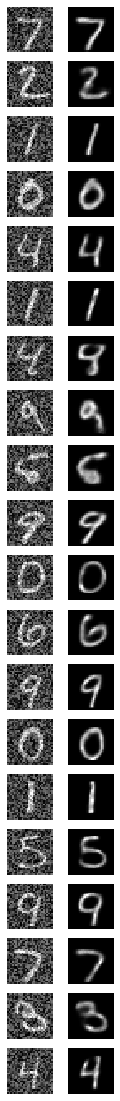

In [116]:
fig = plt.figure(figsize=(2, 20))
for i in range(20):
  inp = np.array([x_test[i]])+np.random.rand(*x_test[i].shape)
  out = auto_encoder(inp)
  out = np.array(out).reshape(28, 28)
  plt.subplot(20, 2, 2*i+1)
  plt.imshow(inp.reshape(28, 28), cmap='gray')
  plt.axis('off')
  plt.subplot(20, 2, 2*i+2)
  plt.imshow(out, cmap='gray')
  plt.axis('off')

Text(0, 0.5, 'Loss')

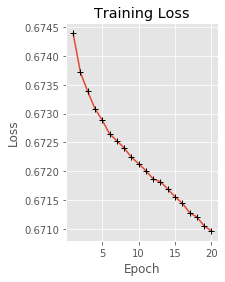

In [138]:
plt.subplot(121)
epochs_list = [*range(1, 21)]
plt.style.use('ggplot')
plt.title('Training Loss')
plt.plot(epochs_list, fit_history.history['loss'], marker='+', markeredgecolor='k')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [0]:
T = models.Model(auto_encoder.input,
                 outputs=[auto_encoder.output,
                          auto_encoder.get_layer(index=2).output]
                 )

In [141]:
test_loss, test_accuracy = auto_encoder.evaluate(x_test, x_test)
print("\nTest Results:\nAccuracy:\t%8.3f %%\nLoss val:\t%8.3f"%
      (test_accuracy*100, test_loss))

10000/10000 [==============================] - 1s 83us/sample - loss: 0.7281 - accuracy: 0.8072

Test Results:
Accuracy:	  80.724 %
Loss val:	   0.728


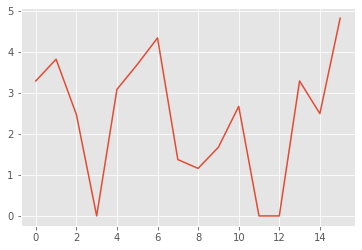

In [142]:
plt.plot(T(x_test)[1][1])

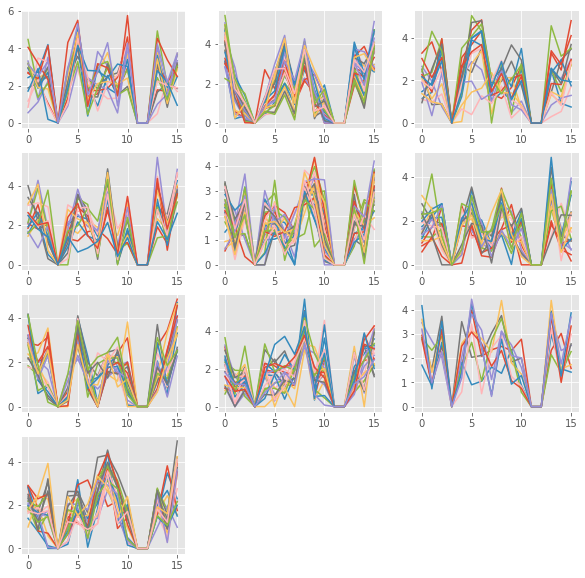

In [148]:
plt.figure(figsize=(10, 10))
for j in range(10):
  if i != 9:
    plt.subplot(4, 3, j+1)
    for num, label in enumerate(label_test[:200]):
      if label == j:
        plt.plot(T(x_test)[1][num])
  else:
    plt.subplot(4, 3, j+1)
    for num, label in enumerate(label_test[:200]):
      if label == j:
        plt.plot(T(x_test)[1][num])

In [165]:
data = T(x_test)[1].numpy()
rep_mat = np.zeros([10, 16])
for num in range(10):
  print("num %3d"%(num))
  z = np.zeros(16)
  for index, datum in enumerate(data):
    if label_test[index] == num:
      z += datum
  rep_mat[num] = z/z.sum()

num   0
num   1
num   2
num   3
num   4
num   5
num   6
num   7
num   8
num   9


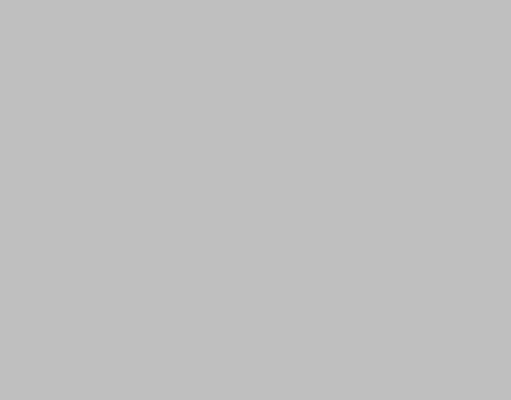

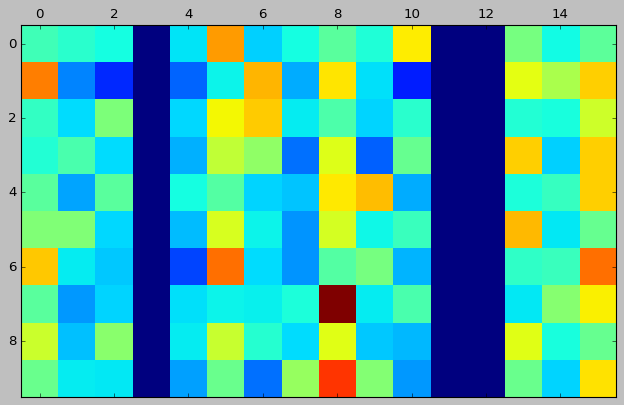

In [170]:
plt.style.use('classic')
plt.axis('off')
plt.matshow(rep_mat, cmap='jet')
plt.show()

In [171]:
auto_encoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_44 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_45 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_46 (Dense)             (None, 64)                1088      
_________________________________________________________________
dense_47 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_48 (Dense)             (None, 784)               101136    
Total params: 220,320
Trainable params: 220,320
Non-trainable params: 0
________________________________________________

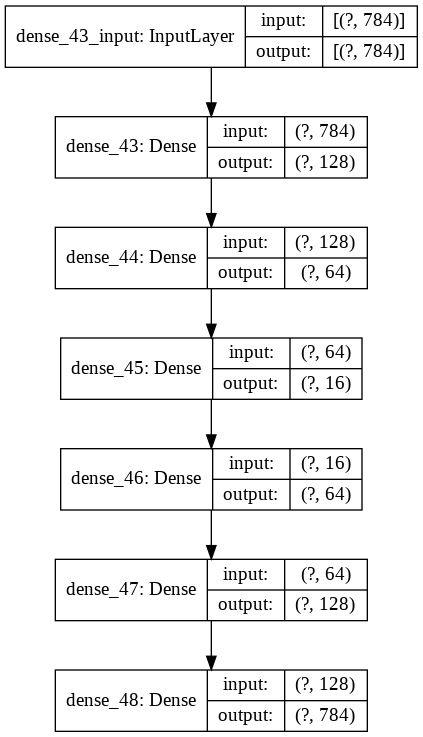

In [177]:
plot_model(auto_encoder, show_shapes=True)

In [0]:
auto_encoder.save('drive/My Drive/AutoEncoder-v0.h5')
#tf.keras.models.load_model('drive/My Drive/AutoEncoder-v0.h5')
#files.download('drive/My Drive/AutoEncoder-v0.h5')